# PyTorch Test -  Roni Halim Saputra

## Import common packages

In [1]:
import torch
from torch import nn, optim

#cek device yang digunakan
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Datasets & DataLoader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 50 #batch size

transform = transforms.Compose([
    transforms.ToTensor() #transform ke tipe data tensor
])

train_set = datasets.MNIST(root='./data',train=True, download=True, transform=transform)
trainLoader = DataLoader(train_set, batch_size =bs, shuffle=True, num_workers=2)

test_set = datasets.MNIST(root='./data',train=False, download=True, transform=transform)
testLoader = DataLoader(test_set, batch_size =bs, shuffle=True, num_workers=2)

In [4]:
train_set #saniti cek data train

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [5]:
test_set #data test

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [6]:
train_set[1] # tensor X,y  data ke 1 

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
# cek dan test dataset dijadikan sesuatu yang iterable
images, labels = next(iter(trainLoader))
# dimensi image
images.shape

torch.Size([50, 1, 28, 28])

In [8]:
#cek kelas dataset
train_set.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [9]:
#simpan jumlah class ke variable 
label2cat = train_set.classes
label2cat

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Arsitektur & Config

In [10]:
from jcopdl.layers import linear_block
from jcopdl.callback import Callback, set_config

In [11]:
class MnistClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(), # Flatten
            linear_block(input_size, n1, dropout=dropout), #linear -> fungsi aktivasi relu -> dropout
            linear_block(n1, n2, dropout=dropout), #linear -> fungsi aktivasi relu -> dropout
            linear_block(n2, output_size, activation="lsoftmax") #linear -> fungsi aktivasi lsoftmax 
        )
    def forward(self,x): #feed forward
        return self.fc(x)

In [12]:
#simpan jumlah parameter yang digunakan 
config = set_config({
    "input_size":784, #jumlah input
    "n1":100, #hidden layer 1
    "n2":50,  #hidden layer 2
    "output_size": len(train_set.classes), #jumlah output
    "dropout":0.2 # nilai dropout
})

## Training Preparation 

In [13]:
model = MnistClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.CrossEntropyLoss() #fungsi Loss
optimizer = optim.Adam(model.parameters(),lr=0.001) #optimizer Adam
callback = Callback(model, config, outdir="model")

In [14]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [15]:
epochs = 20
train_cost,test_cost =[],[]
train_acc,test_acc = [], []
for i in range(epochs):
    cost, acc = loop_fn("train", train_set, trainLoader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    
    with torch.no_grad():
        cost, acc = loop_fn("test", test_set, testLoader, model,criterion, optimizer, device)
        test_cost.append(cost)
        test_acc.append(acc)
        
    print(f"\rEpoch: {i+1}/{epochs} | train_cost :{train_cost[-1]:.4f}| test_cost : {test_cost[-1]:.4f} |" 
          f"train_acc: {train_acc[-1]:.4f}  | test_acc : {test_acc[-1]:.4f} " , end=" " )
        

Epoch: 20/20 | train_cost :0.0507| test_cost : 0.0751 |train_acc: 0.9836  | test_acc : 0.9801  

In [16]:
import matplotlib.pyplot as plt

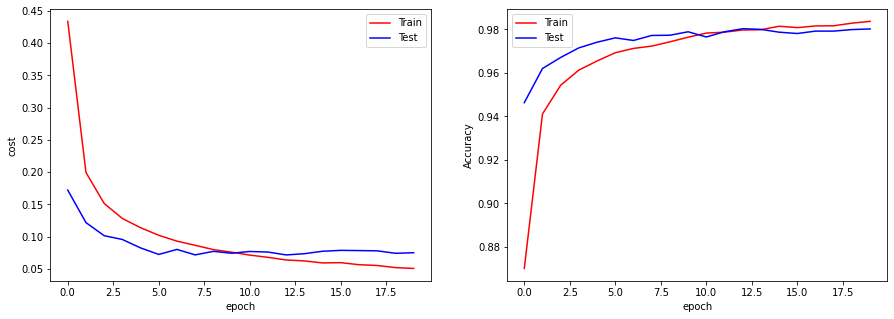

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_cost, 'r-', label = 'Train')
plt.plot(test_cost, 'b-', label = 'Test')
plt.xlabel('epoch'); plt.ylabel('cost'); plt.legend();

plt.subplot(122)
plt.plot(train_acc, 'r-', label = 'Train')
plt.plot(test_acc, 'b-', label = 'Test')
plt.xlabel('epoch'); plt.ylabel('Accuracy'); plt.legend();

In [19]:
  model.state_dict()

OrderedDict([('fc.1.block.linear.weight',
              tensor([[-0.0337,  0.0192,  0.0303,  ..., -0.0242,  0.0241,  0.0319],
                      [ 0.0055, -0.0220, -0.0110,  ..., -0.0079, -0.0108,  0.0082],
                      [ 0.0292, -0.0255, -0.0322,  ..., -0.0090, -0.0101,  0.0137],
                      ...,
                      [-0.0046,  0.0259,  0.0005,  ..., -0.0208, -0.0279, -0.0019],
                      [ 0.0338,  0.0124, -0.0279,  ..., -0.0323,  0.0235,  0.0249],
                      [ 0.0161, -0.0079,  0.0030,  ...,  0.0207, -0.0270,  0.0172]])),
             ('fc.1.block.linear.bias',
              tensor([ 0.2085, -0.0381,  0.2022,  0.2188, -0.0647, -0.0497, -0.1208,  0.0101,
                      -0.0259, -0.1347, -0.3711,  0.0302, -0.0690, -0.1806,  0.1073, -0.2766,
                      -0.2263,  0.0892,  0.0828,  0.0450, -0.1174,  0.0797,  0.1013,  0.0402,
                      -0.0930, -0.3373, -0.0006,  0.0840, -0.0478,  0.0283, -0.1231, -0.3378,
        

## LoadBest Model

In [20]:
#load pada notebook baru
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth" , map_location=ap"cpu")

model = MnistClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
model.load_state_dict(weights)
model = model.to(device)

In [21]:
model

MnistClassifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=784, out_features=100, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (2): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=100, out_features=50, bias=True)
        (relu): ReLU()
        (do): Dropout(p=0.2, inplace=False)
      )
    )
    (3): LinearBlock(
      (block): Sequential(
        (linear): Linear(in_features=50, out_features=10, bias=True)
        (lsoftmax): LogSoftmax(dim=1)
      )
    )
  )
)

## Predict

In [22]:
feature, target = next(iter(testLoader))
feature, target = feature.to(device), target.to(device)

In [25]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['1 - one',
 '5 - five',
 '6 - six',
 '9 - nine',
 '5 - five',
 '9 - nine',
 '5 - five',
 '3 - three',
 '2 - two',
 '6 - six',
 '8 - eight',
 '8 - eight',
 '2 - two',
 '7 - seven',
 '2 - two',
 '3 - three',
 '7 - seven',
 '7 - seven',
 '2 - two',
 '8 - eight',
 '7 - seven',
 '1 - one',
 '1 - one',
 '9 - nine',
 '7 - seven',
 '1 - one',
 '4 - four',
 '9 - nine',
 '5 - five',
 '2 - two',
 '3 - three',
 '1 - one',
 '8 - eight',
 '8 - eight',
 '9 - nine',
 '7 - seven',
 '4 - four',
 '0 - zero',
 '1 - one',
 '9 - nine',
 '3 - three',
 '2 - two',
 '7 - seven',
 '5 - five',
 '2 - two',
 '1 - one',
 '0 - zero',
 '9 - nine',
 '9 - nine',
 '7 - seven']

In [27]:
label2cat[3] #prediksi data ke-3

'3 - three'

## Visualisasi

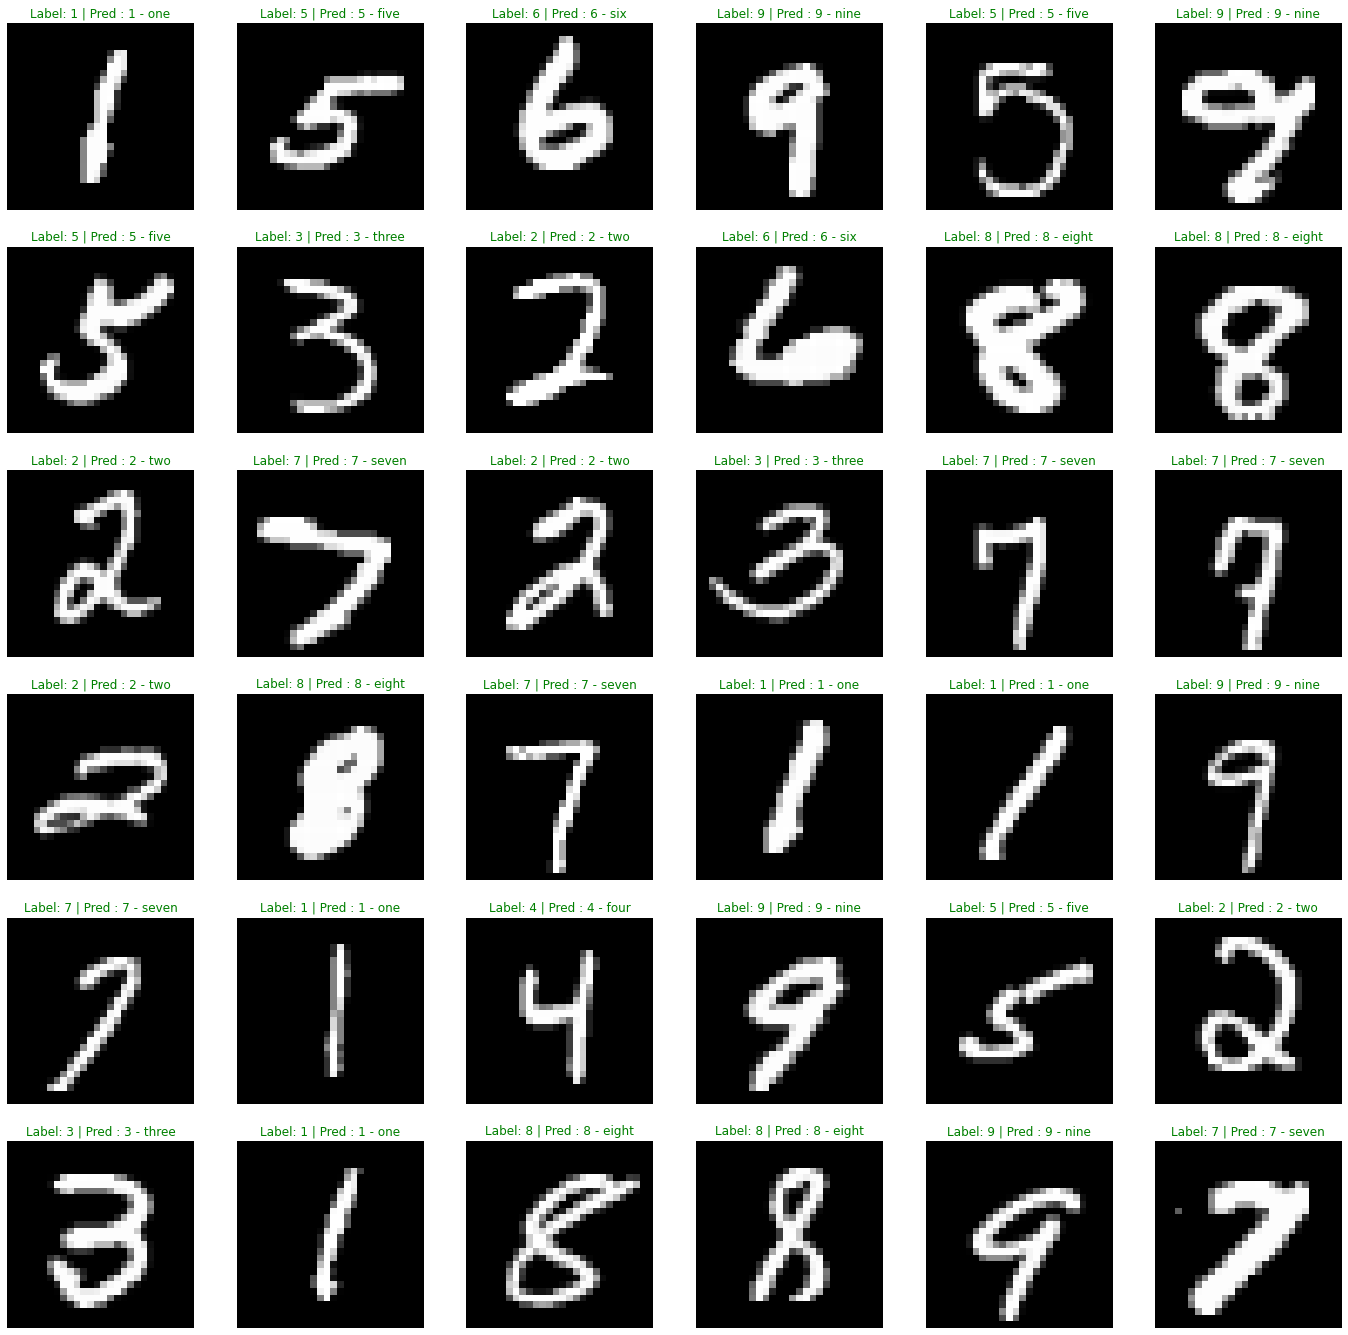

In [28]:
fig, axes = plt.subplots(6,6,figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap='gray')
    font= {"color": 'r'} if label != pred else {"color": 'g'}
    labelbel, pred, =label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred : {pred}", fontdict=font);
    ax.axis('off');